In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split

webis_train = "https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_train.csv"
webis_test = "https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_test.csv"
df_train = pd.read_csv(webis_train)
df_test = pd.read_csv(webis_test)

# Filter only importante variables
# df_train = df_train[['postText', 'truthClass']]
# df_test = df_test[['postText', 'truthClass']]


df_train['truthClass'] = pd.factorize(df_train['truthClass'])[0]
df_test['truthClass'] = pd.factorize(df_test['truthClass'])[0]

df_train, df_valid = train_test_split(df_train, test_size = 0.2, random_state = 42, 
                                  stratify = df_train['truthClass'])


# Load classifier model

In [2]:
!pip install transformers[torch]
!pip install sentencepiece
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 6.8 MB/s 
     |████████████████████████████████| 6.6 MB 18.2 MB/s 
     |████████████████████████████████| 101 kB 8.1 MB/s 
     |████████████████████████████████| 596 kB 34.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 6.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 7.4 MB/s 
     |████████████████████████████████| 212 kB 48.7 MB/s 
     |████████████████████████████████| 1.1 MB 41.9 MB/s 
     |████████████████████████████████| 140 kB 48.2 MB/s 
     |██████████████████████████████

In [3]:
import torch
from transformers import BertModel, BertConfig, PretrainedConfig, PreTrainedModel, AutoModel, AutoConfig
from typing import List, Optional, Tuple, Union
from transformers.modeling_outputs import TokenClassifierOutput,SequenceClassifierOutput
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss, BCELoss
import torch.nn as nn

# weight = torch.FloatTensor(compute_class_weight(class_weight="balanced", classes=[0, 1], y=df_train["truthClass"])).to('cpu')
# WEIGHT = torch.cuda.FloatTensor([weight[1]/weight[0]])

class ClickbaitConfig(PretrainedConfig):
    def __init__(
        self,
        model_type: str = "bert",
        pretrained_model: str = "bert-base-uncased",
        num_labels: int = 2,
        dropout: float = 0.1,
        inner_dim1: int = 256,
        inner_dim2: int = 32, 
        max_length: int = 512,
        load_pretrained: bool = True,
        freeze_bert: bool = True,
        **kwargs
    ):
        super(ClickbaitConfig, self).__init__(num_labels=num_labels, **kwargs)
        self.model_type = model_type
        self.pretrained_model = pretrained_model
        self.dropout = dropout
        self.inner_dim1 = inner_dim1
        self.inner_dim2 = inner_dim2
        self.max_length = max_length
        self.load_pretrained = load_pretrained
        self.freeze_bert = freeze_bert


class BertClickbaitClassifier(PreTrainedModel):
    """
      Taken and extended from BertforSequenceClassification : https://github.com/huggingface/transformers/blob/v4.19.2/src/transformers/models/bert/modeling_bert.py#L1508
    """
    config_class = ClickbaitConfig
    def __init__(self, config: ClickbaitConfig):
        super(BertClickbaitClassifier, self).__init__(config)
        self.num_labels = config.num_labels
        self.config = config
        # self.bert_config = BertConfig.from_pretrained(config.pretrained_model)
        self.bert_config = AutoConfig.from_pretrained(config.pretrained_model)

        # self.bert = BertModel(self.bert_config)
        self.bert = AutoModel.from_pretrained(config.pretrained_model, config=self.bert_config)
        if config.load_pretrained:
            print("Load pretrained weights from {}".format(config.pretrained_model))
            self.bert = self.bert.from_pretrained(config.pretrained_model)
        if config.freeze_bert:
            print("Freeze weights in the BERT model. Just the classifier will be trained")
            for param in self.bert.parameters():
                param.requires_grad = False

        self.linear_1 = nn.Linear(self.bert.config.hidden_size, config.inner_dim1)
        self.dropout_1 = nn.Dropout(config.dropout) 
        self.relu_1 = nn.ReLU()
        self.dropout_2 = nn.Dropout(config.dropout)
        self.linear_2 = nn.Linear(config.inner_dim1, config.inner_dim2)
        self.relu_2 = nn.ReLU()
        self.dropout_3 = nn.Dropout(config.dropout)
        self.classifier = nn.Linear(config.inner_dim2, config.num_labels)
        self.sigmoid = nn.Sigmoid()


    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        output = outputs[0][:,0,:]

        x = self.dropout_1(output)
        x = self.linear_1(x)
        x = self.relu_1(x)
        x = self.dropout_2(x)
        x = self.linear_2(x)
        x = self.relu_2(x)
        x = self.dropout_3(x)

        logits = self.classifier(x)
        logits = self.sigmoid(logits)

        loss = None
        if labels is not None:
            # loss_fct = BCELoss(weight=WEIGHT)
            loss_fct = BCELoss()
            labels = 1.0*labels
            loss = loss_fct(logits.view(-1), labels.view(-1))
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )

In [4]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [5]:
from transformers import AutoModel,AutoTokenizer
classifier_model_path = "drive/MyDrive/nlp_lss_data/mpnet_clickbait_classification_maxlen25/checkpoint-1464"

#Loading classifier
device = 'cuda'
classifier_tokenizer = AutoTokenizer.from_pretrained(classifier_model_path, load_best_model_at_end=True)
classifier_model = BertClickbaitClassifier.from_pretrained(classifier_model_path).to(device)


You passed along `num_labels=2` with an incompatible id to label map: {'0': 'LABEL_0'}. The number of labels wil be overwritten to 1.


Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Load pretrained weights from sentence-transformers/all-mpnet-base-v2


In [6]:
def rate_title(input_text, model, tokenizer, device='cuda'):
  # input_text = {
  #                 "postText": input_text['postText'],
  #                 "truthClass" : input_text['truthClass']
  #              }
  tokenized_input = preprocess_function_title_only_classification(input_text,tokenizer=tokenizer)
  # print(tokenized_input.items())
  dict_tokenized_input = {k : torch.tensor([v]).to(device) for k,v in tokenized_input.items() if k != 'labels'}
  predicted_class = float(model(**dict_tokenized_input).logits)
  actual_class = input_text['truthClass']

  # print(predicted_class, actual_class)
  return {'predicted_class' : predicted_class}


In [7]:
# Start rating 
import numpy as np
from tqdm import tqdm

device = 'cuda'
classifier_model.to(device)
classifier_model.eval()
def preprocess_function_title_only_classification(examples,tokenizer=None):

    if(examples['postText'] is np.nan):
      examples['postText'] = ''
    model_inputs = tokenizer(examples['postText'], padding="longest", truncation=True, max_length=25)
      
    model_inputs['labels'] = examples['truthClass']

    return model_inputs

tqdm.pandas()
# examples['postText']
df_test['postText_score'] = df_test['postText'].progress_apply(lambda x : rate_title(
      input_text = {'postText' : x,
                    'truthClass' : 1}, #doesn't matter,

      model=classifier_model,
      tokenizer=classifier_tokenizer,
      device=device
)['predicted_class'])

# df_test['targetTitle_score'] = df_test['targetTitle'].apply(lambda x : rate_title(
#       input_text = {'postText' : x,
#                     'truthClass' : 1}, #doesn't matter,
#       model=classifier_model.to('cpu'),
#       tokenizer=classifier_tokenizer,
#       device='cpu'
# ))
   


 13%|█▎        | 2402/18979 [00:36<04:11, 65.94it/s]


KeyboardInterrupt: ignored

In [ ]:
df_train['postText_score'] = df_train['postText'].progress_apply(lambda x : rate_title(
      input_text = {'postText' : x,
                    'truthClass' : 1}, #doesn't matter,

      model=classifier_model,
      tokenizer=classifier_tokenizer,
      device=device
)['predicted_class'])

In [ ]:
df_test['postText_score']

In [ ]:
df_test.to_csv('drive/MyDrive/nlp_lss_data/webis_test_with_classifier_prediction.csv')
df_test.to_csv('drive/MyDrive/nlp_lss_data/webis_train_with_classifier_prediction.csv')

# Dataset Analysis - main

## Sample of clickbait titles by grade, and what to expect in general

In [ ]:
df_train.iloc[3137]

Unnamed: 0                                                       10063
postMedia                       ['media/photo_849300764178644992.jpg']
postText                  The Warriors are right where they want to be
id                                                  849301292694605824
targetCaptions       ['Golden State Warriors logo', "Golden State W...
targetParagraphs     ['OAKLAND, Calif. — He is the most qualified p...
targetTitle          Stephen Curry: 'It's Comical That People [Are]...
postTimestamp                           Tue Apr 04 16:43:02 +0000 2017
targetKeywords       Basketball, NBA, NBA Pacific, Golden State War...
targetDescription    OAKLAND, Calif. — He is the most qualified per...
truthJudgments                [0.0, 0.6666666666000001, 0.0, 0.0, 0.0]
truthMean                                                     0.133333
truthClass                                                           0
truthMedian                                                        0.0
truthM

In [ ]:
number = 0.30
epsilon = 0.15

clickbait_labels = {
    'no-clickbait' : 0,
    'slightly-clickbait' : 0.33,
    'likely-clickbait' : 0.66,
    'clickbait' : 1.0
}
def return_clickbait_label(number, epsilon=0.15):
  for k,v in clickbait_labels.items():
    if(abs(number - v) <= epsilon):
      # print(number, k)
      return (number, k)


return_clickbait_label(number)

(0.3, 'slightly-clickbait')

In [ ]:
df_train.iloc[3137]

Unnamed: 0                                                       10063
postMedia                       ['media/photo_849300764178644992.jpg']
postText                  The Warriors are right where they want to be
id                                                  849301292694605824
targetCaptions       ['Golden State Warriors logo', "Golden State W...
targetParagraphs     ['OAKLAND, Calif. — He is the most qualified p...
targetTitle          Stephen Curry: 'It's Comical That People [Are]...
postTimestamp                           Tue Apr 04 16:43:02 +0000 2017
targetKeywords       Basketball, NBA, NBA Pacific, Golden State War...
targetDescription    OAKLAND, Calif. — He is the most qualified per...
truthJudgments                [0.0, 0.6666666666000001, 0.0, 0.0, 0.0]
truthMean                                                     0.133333
truthClass                                                           0
truthMedian                                                        0.0
truthM

In [ ]:
df_train['postText'].count(), df_train['postText'].dropna().count()

(15589, 15589)

In [ ]:
from tqdm import tqdm
import numpy as np
clickbait_type_samples = {k : [] for k,v in clickbait_labels.items()}



for i in tqdm(range(df_train.shape[0])):
  truthMean, label_name = return_clickbait_label(df_train.iloc[i]['truthMean'])

  if(df_train.iloc[i]['postText'] is np.nan):
    # print('Found one')
    continue
    # print(df_train.iloc[i]['postText'])
  else:
    clickbait_type_samples[label_name].append(df_train.iloc[i]['postText'])

  # print(df_train.iloc[i]['postText'],truthMean, label_name)

100%|██████████| 15630/15630 [00:11<00:00, 1336.85it/s]


In [ ]:
df_train.iloc[371]['postText'] is np.nan

True

In [ ]:

clickbait_type_samples['likely-clickbait'][0:10]

for k,v in clickbait_type_samples.items():
  print(k)
  # print(v[0:10])
  for i,title in enumerate(v[0:10]):
    print(f'{i}. {title}')
  print('__' * 30)

no-clickbait
0. Rep. Adam Schiff says Russia was "absolutely" complicit in Syrian chemical attack  #ThisWeek
1. Buzz Aldrin: Altitude sickness forced South Pole evacuation
2. Jordan Peele's racism-tackling debut "Get Out" earns $30.5 million
3. This #CRPFJawan is the latest to join the list of men in uniform venting out against government apathy. #SukmaAttack
4. Samsung says flaws in Note 7's battery design, manufacture caused fires
5. Clapper denies Trump wiretap as White House demands a probe
6. George H.W. Bush and Barbara Bush celebrate 72 years of marriage
7. A Thunder fan stole the show by making a $20,000 shot from half court last night 🤑 

🎥:
8. Dwyane Wade (wrist), Jimmy Butler (heel) will miss today’s game vs. Timberwolves
9. Shia LaBeouf launches four year anti-Trump art project
____________________________________________________________
slightly-clickbait
0. Trump reverses course in 24 hours from Nato to China to Fed
1. President Trump says H&amp;R Block will be unhappy wi

In [ ]:
# !pip install wordcloud
# !pip install multidict

# Preprocessing done with stopwords and numbers included, since we want to see most frequently used phrases and not named entities

In [8]:
import nltk
nltk.download('stopwords')
  
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc, remove_stopwords=False):
    "Input doc and return clean list of tokens"
    # print(len(doc))
    doc = doc.replace('\r', ' ').replace('\n', ' ').replace("Subscribe now for full access or register to continue reading Subscribe now for full access or register to continue", "")
    # print(len(doc))
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    # nostop = [w for w in words if w not in stoplist] # remove stopwords
    # no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    # stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    # stemmed = [stemmer.stem(w) for w in nostop] # stem each word
    stemmed = [stemmer.stem(w) for w in words] # stem each word
    return stemmed

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
normalized_text_input = normalize_text(" ".join(clickbait_type_samples['no-clickbait']))

In [ ]:
"subscrib now" in " ".join(normalized_text_input)

False

In [ ]:
!pip install multidict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 94 kB 2.0 MB/s 


In [ ]:
import multidict as multidict
import re

def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        # if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be|\d+|#", text):
        #     continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict

# clickbait_type_samples['clickbait']
result_dict = getFrequencyDictForText(" ".join(normalized_text_input))

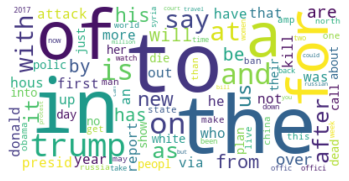

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wc = WordCloud(background_color="white", max_words=100)

wc.generate_from_frequencies(result_dict)

# show
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


In [ ]:
import nltk
nltk.download('all')

#Create your bigrams
bgs = nltk.ngrams(normalized_text_input,n=2)
#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(bgs)

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

In [ ]:
from collections import Counter 

Counter(fdist).most_common()[:8]

[(('in', 'the'), 136),
 (('donald', 'trump'), 132),
 (('of', 'the'), 126),
 (('to', 'the'), 84),
 (('white', 'hous'), 81),
 (('on', 'the'), 70),
 (('presid', 'trump'), 67),
 (('for', 'the'), 67)]

In [ ]:
 # get n-gram counts for 10 documents
grams = []
# for i, row in df.iterrows():
# tokens = row['opinion_text'].lower().split() # get tokens
# tokens = " ".join(clickbait_type_samples['clickbait']).lower().split()
tokens = normalized_text_input
for n in range(2,4):
    grams += list(nltk.ngrams(tokens,n)) # get bigrams, trigrams, and quadgrams

Counter(grams).most_common()[:15]  # most frequent n-grams

[(('in', 'the'), 136),
 (('donald', 'trump'), 132),
 (('of', 'the'), 126),
 (('to', 'the'), 84),
 (('white', 'hous'), 81),
 (('on', 'the'), 70),
 (('presid', 'trump'), 67),
 (('for', 'the'), 67),
 (('at', 'least'), 58),
 (('to', 'be'), 57),
 (('the', 'us'), 56),
 (('at', 'the'), 54),
 (('more', 'than'), 50),
 (('north', 'korea'), 50),
 (('plan', 'to'), 48)]

In [ ]:
wordcloud_prepared_grams = [" ".join(gram) for gram in grams]

In [ ]:
wordcloud_prepared_grams[0], grams[0]

('rep adam', ('rep', 'adam'))

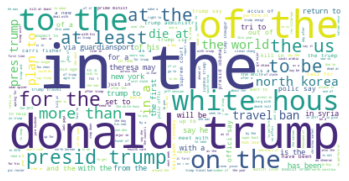

In [ ]:
fdist = nltk.FreqDist(wordcloud_prepared_grams)
wc = WordCloud(background_color="white", max_words=1000)
filter_words = dict([(m, n) for m, n in fdist.items() if len(m) > 3])

wc.generate_from_frequencies(filter_words)

# show
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


# For n = 2,3,4,5 grams

In [ ]:
n_gram_sizes = [2,3,4,5]
# get n-gram counts for 10 documents
# grams = []
grams = {n_gram_size : [] for n_gram_size in n_gram_sizes}

tokens = normalized_text_input
# for n in range(2,4):
for n_gram_size in n_gram_sizes:
    # grams += list(nltk.ngrams(tokens,n)) # get bigrams, trigrams, and quadgrams
    grams[n_gram_size] = list(nltk.ngrams(tokens, n_gram_size))

In [ ]:
'subscrib' in normalized_text_input

False

In [ ]:
filter_words

{'at the 2017 billboard latin': 3,
 'drop mother of all bomb': 3,
 'for the first time in': 5,
 'hous press secretari sean spicer': 3,
 'leagu – live via guardiansport': 3,
 'leav 24 million more uninsur': 3,
 'premier leagu – live via': 3,
 'set to perform at the': 3,
 'the 2017 billboard latin music': 3,
 'white hous press secretari sean': 4}

In [ ]:
list(filter_words.keys())

['white hous press secretari sean',
 'hous press secretari sean spicer',
 'leav 24 million more uninsur',
 'for the first time in',
 'drop mother of all bomb',
 'premier leagu – live via',
 'leagu – live via guardiansport',
 'set to perform at the',
 'at the 2017 billboard latin',
 'the 2017 billboard latin music']

In [ ]:
# list(filter_words.values())
filter_words_sorted = sorted(filter_words.items(), reverse=True)

for ngram in filter_words_sorted:
new_row = {'n-gram': ngram[0], 'frequency':ngram[1]} 
df_filter_words.append(new_row, ignore_index = True)

[('white hous press secretari sean', 4),
 ('the 2017 billboard latin music', 3),
 ('set to perform at the', 3),
 ('premier leagu – live via', 3),
 ('leav 24 million more uninsur', 3),
 ('leagu – live via guardiansport', 3),
 ('hous press secretari sean spicer', 3),
 ('for the first time in', 5),
 ('drop mother of all bomb', 3),
 ('at the 2017 billboard latin', 3)]

In [ ]:
def print_latex_code(filter_words, label, n_gram_size):
  df_filter_words = pd.DataFrame(columns = ['n-gram', 'frequency'])
  df_filter_words['n-gram'] = list(filter_words.keys())
  df_filter_words['frequency'] = list(filter_words.values())

  # label = 'no-clickbait'
  # print(df_filter_words.to_latex(index=False, column_format='c|c', caption = f'Most frequent {n_gram_size}-grams for {label}'))
  latex_code = df_filter_words.sort_values(by='frequency', ascending=False).to_latex(index=False, column_format='|c|c|', caption = f'Most frequent {n_gram_size}-grams for {label}')
  latex_code = latex_code.replace("\\\n", "\\ \hline\n")
  print(latex_code)

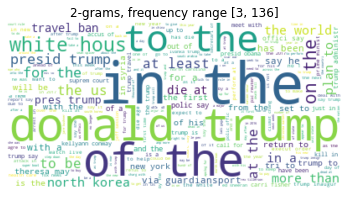

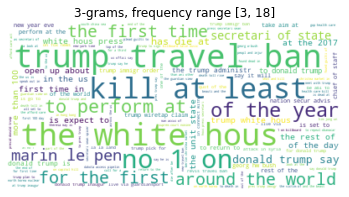

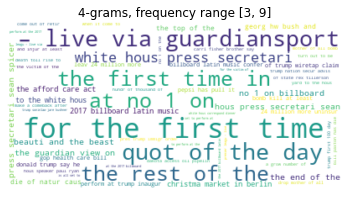

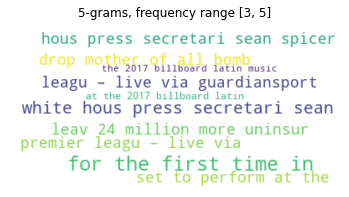

In [ ]:
for n_gram_size in n_gram_sizes:
  wordcloud_prepared_grams = [" ".join(gram) for gram in grams[n_gram_size]]
  fdist = nltk.FreqDist(wordcloud_prepared_grams)
  wc = WordCloud(background_color="white", max_words=1000)
  filter_words = dict([(m, n) for m, n in fdist.items() if len(m) > 3 and n > 2])

  wc.generate_from_frequencies(filter_words)


  # show
  min_frequency = min(filter_words.values())
  max_frequency = max(fdist.values())
  title = f'{n_gram_size}-grams, frequency range [{min_frequency}, {max_frequency}]'
  plt.title(title)
  plt.imshow(wc, interpolation="bilinear")
  plt.axis("off")
  plt.show()


## Make a function where every subset of clickbait grades will be considered

In [ ]:
def visualize_wordclouds(doc, label='clickbait'):
  # normalized_text_input = normalize_text(" ".join(clickbait_type_samples['clickbait']))
  normalized_text_input = normalize_text(" ".join(doc[label]))
  # result_dict = getFrequencyDictForText(" ".join(normalized_text_input))

  n_gram_sizes = [2,3,4,5] #,6,7,8] 
  grams = {n_gram_size : [] for n_gram_size in n_gram_sizes}

  tokens = normalized_text_input

  #Make n_grams for each size
  for n_gram_size in n_gram_sizes:
      grams[n_gram_size] = list(nltk.ngrams(tokens, n_gram_size))

  #Plot n_gram wordcloud for each size
  for n_gram_size in n_gram_sizes:
    wordcloud_prepared_grams = [" ".join(gram) for gram in grams[n_gram_size]]
    fdist = nltk.FreqDist(wordcloud_prepared_grams)
    wc = WordCloud(background_color="white", max_words=1000)
    filter_words = dict([(m, n) for m, n in fdist.items() if len(m) > 3 and n > 2])

    wc.generate_from_frequencies(filter_words)

    if(n_gram_size == 3):
      print_latex_code(filter_words=filter_words, label=label, n_gram_size=n_gram_size)

    # show
    min_frequency = min(filter_words.values())
    max_frequency = max(fdist.values())
    title = f'{label} : {n_gram_size}-grams, frequency range [{min_frequency}, {max_frequency}]'
    plt.title(title)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

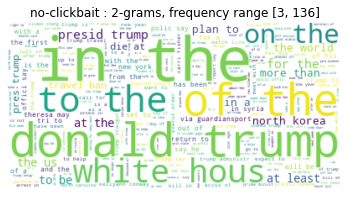

\begin{table}
\centering
\caption{Most frequent 3-grams for no-clickbait}
\begin{tabular}{|c|c|}
\toprule
                       n-gram &  frequency \\ \hline
\midrule
             trump travel ban &         18 \\ \hline
               the white hous &         17 \\ \hline
                kill at least &         15 \\ \hline
                      no 1 on &         12 \\ \hline
                  of the year &         12 \\ \hline
                to perform at &         11 \\ \hline
                 marin le pen &          9 \\ \hline
               the first time &          9 \\ \hline
                for the first &          9 \\ \hline
             around the world &          9 \\ \hline
             donald trump say &          8 \\ \hline
           secretari of state &          8 \\ \hline
                  the rest of &          7 \\ \hline
              to donald trump &          7 \\ \hline
                more than 100 &          7 \\ \hline
              donald trump is &      

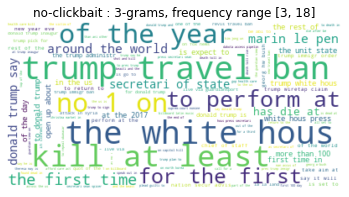

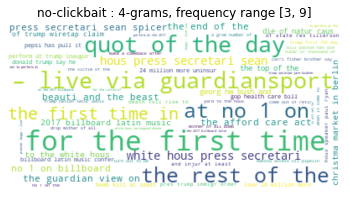

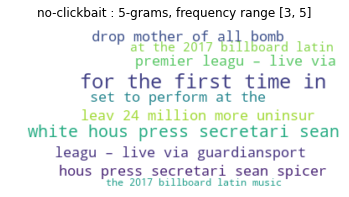

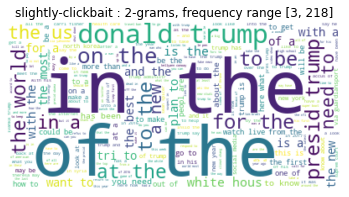

\begin{table}
\centering
\caption{Most frequent 3-grams for slightly-clickbait}
\begin{tabular}{|c|c|}
\toprule
                      n-gram &  frequency \\ \hline
\midrule
                 you need to &         35 \\ \hline
                need to know &         31 \\ \hline
               what you need &         21 \\ \hline
               to know about &         20 \\ \hline
                  one of the &         20 \\ \hline
                   in the us &         18 \\ \hline
              the white hous &         17 \\ \hline
               here what you &         15 \\ \hline
              game of throne &         14 \\ \hline
              the world most &         14 \\ \hline
                 look at the &         14 \\ \hline
                marin le pen &         13 \\ \hline
                   a look at &         11 \\ \hline
                in the world &         11 \\ \hline
                new year eve &         11 \\ \hline
                 of the year &         11 \\ \h

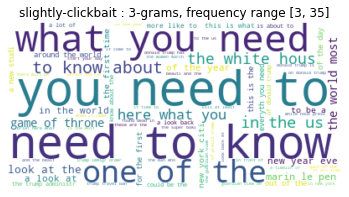

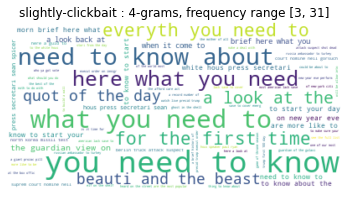

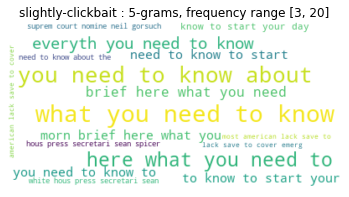

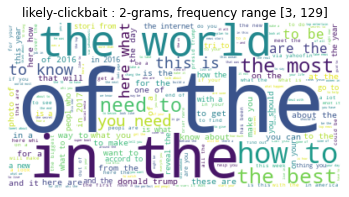

\begin{table}
\centering
\caption{Most frequent 3-grams for likely-clickbait}
\begin{tabular}{|c|c|}
\toprule
              n-gram &  frequency \\ \hline
\midrule
         you need to &         51 \\ \hline
        need to know &         38 \\ \hline
       these are the &         25 \\ \hline
        in the world &         21 \\ \hline
       what you need &         21 \\ \hline
       to know about &         18 \\ \hline
        this is what &         16 \\ \hline
       here what you &         15 \\ \hline
          one of the &         15 \\ \hline
        from the day &         14 \\ \hline
         of the most &         13 \\ \hline
      stori from the &         13 \\ \hline
       will make you &         12 \\ \hline
        here are the &         11 \\ \hline
     brief here what &         11 \\ \hline
      know about the &         11 \\ \hline
      the world most &         10 \\ \hline
     news stori from &         10 \\ \hline
         of the year &         10 \\ \hline
 

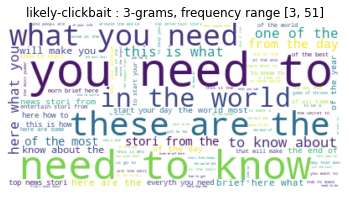

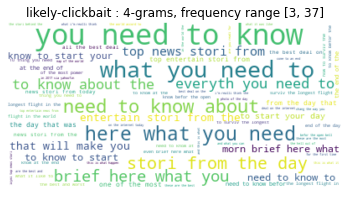

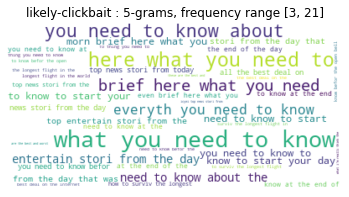

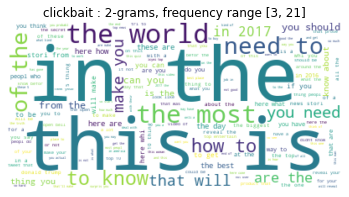

\begin{table}
\centering
\caption{Most frequent 3-grams for clickbait}
\begin{tabular}{|c|c|}
\toprule
          n-gram &  frequency \\ \hline
\midrule
     you need to &         13 \\ \hline
    need to know &         10 \\ \hline
    from the day &          7 \\ \hline
   these are the &          7 \\ \hline
    in the world &          6 \\ \hline
  thing you need &          6 \\ \hline
   to know about &          6 \\ \hline
  that will make &          6 \\ \hline
   will make you &          5 \\ \hline
  stori from the &          5 \\ \hline
 news stori from &          5 \\ \hline
   to know befor &          4 \\ \hline
around the world &          4 \\ \hline
      the top 10 &          4 \\ \hline
   the open bell &          4 \\ \hline
  know befor the &          4 \\ \hline
  befor the open &          4 \\ \hline
    10 thing you &          4 \\ \hline
    the day that &          4 \\ \hline
   you should be &          4 \\ \hline
     this is the &          4 \\ \hline
    make

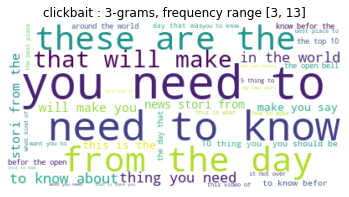

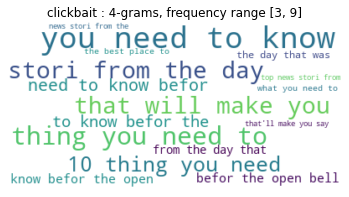

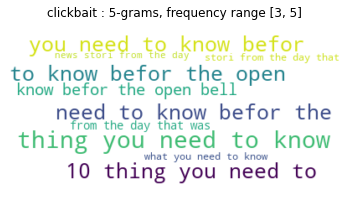

In [ ]:
for k,v in clickbait_type_samples.items():
  visualize_wordclouds(clickbait_type_samples, label=k)


# LDA to get different topics for targetTitle and find clickbait classifier score according to these topic groups

In [ ]:
#https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-ea3ebb2be9f4
#https://www.analyticsvidhya.com/blog/2021/06/part-3-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/
import nltk
nltk.download('stopwords')
  
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

donald_list = ['donald', 'trump']
def normalize_text_no_stop_no_trump(doc, remove_stopwords=False):
    "Input doc and return clean list of tokens"
    # print(len(doc))
    doc = doc.replace('\r', ' ').replace('\n', ' ').replace("Subscribe now for full access or register to continue reading Subscribe now for full access or register to continue", "")
    # print(len(doc))
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words if w not in stoplist] # remove stopwords
    stemmed = [stemmer.stem(w) for w in nostop] # stem each word
    # no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    # stemmed = [stemmer.stem(w) for w in words] # stem each word


    no_trump = [w for w in stemmed if w not in donald_list]
    # return stemmed
    return no_trump

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df_test

,Unnamed: 0,id,postMedia,targetCaptions,postText,postTimestamp,targetTitle,targetDescription,targetKeywords,targetParagraphs,truthJudgments,truthClass,truthMedian,truthMode,truthMean,postText_score
0,0,858426904239497216,['media/photo_858425825229549568.jpg'],"['Cleveland Browns logo', 'Dec 6, 2015; Clevel...",Johnny Manziel on Browns' No. 1 pick Myles Gar...,Sat Apr 29 21:04:57 +0000 2017,Johnny Manziel Says Top Pick in Draft Myles Ga...,Johnny Manziel approves of the Cleveland ...,"NFL Draft, Football, NFL, AFC North, Cleveland...","[""Johnny Manziel approves of the Cleveland Bro...","[0.0, 0.0, 0.0, 0.0, 0.0]",0,0.000000,0.000000,0.000000,0.012975
1,1,858416350540201984,['media/photo_858416342268911616.jpg'],"['Five', 'Guilfoyle', 'Coulter', 'Cain']",Fabio: California Is a 'Mess' Because of Liber...,Sat Apr 29 20:23:01 +0000 2017,Fabio: California Is a 'Mess' Because of Liber...,"Fabio, the Italian-born male model who has ado...",NaN,"['Fabio, the Italian-born male model who has a...","[0.0, 0.0, 0.0, 0.33333333330000003, 0.0]",0,0.000000,0.000000,0.066667,0.013491
2,2,858364015260704768,[],[],"""He's been huge for us this year, man.""",Sat Apr 29 16:55:03 +0000 2017,"Jimmy Butler wants to return, hopes Bulls keep...",Bulls guard Jimmy Butler says he wants to rema...,"guards, backcourt, option, contract, Chicago B...","[""CHICAGO -- All-Star swingman Jimmy Butler kn...","[1.0, 1.0, 1.0, 1.0, 1.0]",1,1.000000,1.000000,1.000000,0.398016
3,3,858335817693102080,[],"['NFL Draft', ""Trubisky hasn't warranted ire o...",New Bears quarterback Mitchell Trubisky was gr...,Sat Apr 29 15:03:00 +0000 2017,Mitchell Trubisky booed at United Center durin...,A day after he was drafted second overall by t...,"booed, jumbotron, united center, Mitchell Trub...",['CHICAGO -- New Bears quarterback Mitchell Tr...,"[0.33333333330000003, 0.0, 1.0, 0.0, 0.0]",0,0.000000,0.000000,0.266667,0.013082
4,4,858326196282679296,['media/photo_858326194076491777.jpg'],[],It's not enough to let employees work flexible...,Sat Apr 29 14:24:46 +0000 2017,It's Not Enough to Give Employees Flexible Wor...,They need to know their options—and they're af...,game-plan,"['Six months after her baby was born, Amanda S...","[0.33333333330000003, 0.0, 0.0, 0.0, 0.3333333...",0,0.000000,0.000000,0.133333,0.014002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18974,18974,804222497700843520,['media/photo_804222494882336768.jpg'],['Whitney Tilson'],Whitney Tilson on Trump's supporters: 'I think...,Thu Dec 01 07:15:59 +0000 2016,Whitney Tilson on Trump's supporters: 'I think...,"The hedge funder says he ""can take glee"" in kn...",NaN,"['Bryan Logan', '1.12.2016, 08:15 96', 'facebo...","[0.0, 0.0, 0.33333333330000003, 0.0, 0.3333333...",0,0.000000,0.000000,0.133333,0.012916
18975,18975,804214438744227840,['media/photo_804214435623665664.jpg'],"['PHOTO: Big Mac creator Michael ""Jim"" Delliga...",The McDonald’s franchisee who created the Big ...,Thu Dec 01 06:43:58 +0000 2016,"Creator of McDonald's Flagship Sandwich, the B...","Creator of McDonald's Flagship Sandwich, the B...","Business, Food and drink, General news, Lifest...","[""You probably don't know his name, but you've...","[0.0, 0.6666666666000001, 0.0, 0.0, 0.0]",0,0.000000,0.000000,0.133333,0.013081
18976,18976,804188646597197824,['media/photo_804188474509180929.jpg'],['President Juan Manuel Santos (L) signed the ...,Colombian Congress passes second #FARC peace d...,Thu Dec 01 05:01:29 +0000 2016,Colombian Congress passes revised FARC peace d...,"After five decades of war, more than four year...","farc, juan manuel santos, peace deal","[""Colombia's Congress has ratified the revised...","[0.0, 0.0, 0.0, 0.0, 0.0]",0,0.000000,0.000000,0.000000,0.012963
18977,18977,804182013892841472,['media/photo_804182011917303808.jpg'],['Australian startups needs more skilled tech ...,Australian startups need more diversity to thr...,Thu Dec 01 04:35:07 +0000 2016,Australian startups need more diversity to thr...,"

In [ ]:
df_test['postText']

0        Johnny Manziel on Browns' No. 1 pick Myles Gar...
1        Fabio: California Is a 'Mess' Because of Liber...
2                  "He's been huge for us this year, man."
3        New Bears quarterback Mitchell Trubisky was gr...
4        It's not enough to let employees work flexible...
                               ...                        
18974    Whitney Tilson on Trump's supporters: 'I think...
18975    The McDonald’s franchisee who created the Big ...
18976    Colombian Congress passes second #FARC peace d...
18977    Australian startups need more diversity to thr...
18978    35 gifts for the wanderlust-obsessed person in...
Name: postText, Length: 18979, dtype: object

In [ ]:
# normalized_text_input = normalize_text(" ".join(df_test[]))
# normalized_text_input = 
# normalize_text(df_test['postText'].iloc[0])
import numpy as np
def prepare_postText(x):
  if(x is np.nan):
    return ['']
  return normalize_text_no_stop_no_trump(x)
df_test['normalized_postText'] = df_test['postText'].apply(lambda x: prepare_postText(x))
df_test['normalized_postText']

0        [johnni, manziel, brown, #, pick, myle, garret...
1                 [fabio, california, mess, liber, polici]
2                               [hes, huge, us, year, man]
3        [new, bear, quarterback, mitchel, trubiski, gr...
4        [enough, let, employe, work, flexibl, schedul,...
                               ...                        
18974               [whitney, tilson, support, think, con]
18975    [mcdonald, franchise, creat, big, mac, near, #...
18976    [colombian, congress, pass, second, farc, peac...
18977    [australian, startup, need, divers, thrive, cl...
18978            [#, gift, wanderlustobsess, person, life]
Name: normalized_postText, Length: 18979, dtype: object

In [ ]:
import gensim.corpora as corpora
# Create Dictionary

data_words = [text for text in df_test['normalized_postText']]
id2word = corpora.Dictionary(data_words)

corpus = [id2word.doc2bow(text) for text in df_test['normalized_postText']]


In [ ]:
import gensim
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.036*"#" + 0.007*"year" + 0.006*"best" + 0.005*"stori" + 0.005*"christma" '
  '+ 0.005*"say" + 0.005*"kill" + 0.004*"get" + 0.004*"may" + 0.004*"women"'),
 (1,
  '0.008*"new" + 0.006*"vote" + 0.006*"obama" + 0.006*"#" + 0.006*"get" + '
  '0.006*"say" + 0.005*"presid" + 0.005*"back" + 0.004*"hous" + 0.004*"us"'),
 (2,
  '0.009*"say" + 0.007*"court" + 0.007*"north" + 0.007*"one" + 0.006*"watch" + '
  '0.005*"presid" + 0.005*"confirm" + 0.005*"twitter" + 0.005*"#" + '
  '0.004*"korea"'),
 (3,
  '0.006*"call" + 0.005*"star" + 0.005*"#" + 0.005*"war" + 0.005*"report" + '
  '0.005*"border" + 0.004*"say" + 0.004*"presid" + 0.004*"help" + '
  '0.004*"wall"'),
 (4,
  '0.015*"#" + 0.009*"new" + 0.006*"us" + 0.006*"via" + 0.006*"bill" + '
  '0.005*"news" + 0.005*"year" + 0.005*"like" + 0.005*"say" + 0.004*"best"'),
 (5,
  '0.051*"#" + 0.006*"new" + 0.005*"us" + 0.005*"say" + 0.004*"watch" + '
  '0.004*"year" + 0.003*"best" + 0.003*"number" + 0.003*"meet" + 0.003*"babi"'),
 (6,
  '0.011*"

In [ ]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import numpy as np 

best_num = float('NaN')
best_score = 0

# compute the coherence scores for each number of topics
for i in range(2,20):
    
    # create lda model with i topics
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=i,
                                       random_state=42)
    # lda = LdaModel(corpus=bow, 
    #                num_topics=i, 
    #                id2word=id2word, 
    #                random_state=42)
    
    # obtain the coherence score
    coherence_model = CoherenceModel(model=lda_model, 
                                     texts=data_words, 
                                    #  dictionary=id2word, #not needed according to docs
                                     coherence='c_v')
    coherence_score = np.round(coherence_model.get_coherence(),2)
    print(f'coherence_score : {coherence_score}')
    if coherence_score > best_score:
        best_num = i
        best_score = coherence_score

print(f'The coherence score is highest ({best_score}) with {best_num} topics.')

coherence_score : 0.21
coherence_score : 0.22
coherence_score : 0.17
coherence_score : 0.21
coherence_score : 0.21
coherence_score : 0.21
coherence_score : 0.24
coherence_score : 0.26
coherence_score : 0.25
coherence_score : 0.27
coherence_score : 0.3
coherence_score : 0.31
coherence_score : 0.31
coherence_score : 0.31
coherence_score : 0.34
coherence_score : 0.34
coherence_score : 0.36
coherence_score : 0.35
The coherence score is highest (0.36) with 18 topics.


In [ ]:
# best_num = 18
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=best_num)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.028*"#" + 0.018*"new" + 0.007*"take" + 0.007*"want" + 0.006*"say" + '
  '0.005*"chang" + 0.005*"amp" + 0.005*"video" + 0.005*"song" + '
  '0.004*"street"'),
 (1,
  '0.012*"us" + 0.011*"#" + 0.009*"court" + 0.009*"say" + 0.009*"nation" + '
  '0.005*"suprem" + 0.004*"countri" + 0.004*"pull" + 0.004*"russian" + '
  '0.004*"russia"'),
 (2,
  '0.021*"#" + 0.008*"year" + 0.008*"girl" + 0.007*"us" + 0.007*"explain" + '
  '0.006*"say" + 0.005*"new" + 0.005*"women" + 0.004*"surpris" + '
  '0.004*"golden"'),
 (3,
  '0.038*"#" + 0.013*"best" + 0.010*"day" + 0.009*"christma" + 0.009*"peopl" + '
  '0.008*"get" + 0.007*"internet" + 0.007*"ever" + 0.006*"year" + 0.006*"top"'),
 (4,
  '0.014*"say" + 0.010*"#" + 0.008*"attack" + 0.006*"berlin" + 0.006*"suspect" '
  '+ 0.006*"kill" + 0.005*"forc" + 0.005*"christma" + 0.005*"via" + '
  '0.005*"new"'),
 (5,
  '0.010*"say" + 0.008*"us" + 0.008*"obama" + 0.008*"year" + 0.007*"presid" + '
  '0.007*"#" + 0.006*"new" + 0.006*"could" + 0.006*"attack" 

In [ ]:
df_test.insert(0,'lda', doc_lda)

In [ ]:
# lda_model[df_test.iloc[0]['postText']]
def return_max_topic(input_list_tuples):
  max_val = 0
  max_topic = np.nan
  for input_tuple in input_list_tuples:
    if(input_tuple[1] > max_val):
      max_val = input_tuple[1]
      max_topic = input_tuple[0]

  return max_topic

# max_topic_li
# for lda_predict, classifier_score in tqdm(zip(df_test['lda'], df_test['postText_score'].tolist())):
#   # print(lda_predict, classifier_score)
#   print(lda_predict[0])
#   break

df_test['chosen_lda_topic'] = df_test['lda'].progress_apply(lambda x: return_max_topic(x))

100%|██████████| 18979/18979 [00:00<00:00, 136775.40it/s]


In [ ]:
df_test['chosen_lda_topic']

0        14
1         7
2         9
3         2
4        10
         ..
18974     4
18975    16
18976    13
18977     6
18978    15
Name: chosen_lda_topic, Length: 18979, dtype: int64

In [ ]:
pprint(lda_model.print_topics())


LdaModel(num_terms=17489, num_topics=18, decay=0.5, chunksize=2000)


In [ ]:
from sklearn.metrics import classification_report,precision_score, accuracy_score, f1_score, recall_score

def get_classification_report(df):
  # print(classification_report(1 * (df['postText_score'] > 0.5), df['truthClass']))
  y_pred = 1 * (df['postText_score'] > 0.5)
  y_true = df['truthClass']
  print({
      'precision_score' : precision_score(y_pred, y_true),
      'accuracy_score' : accuracy_score(y_pred, y_true),
      'recall_score' : recall_score(y_pred, y_true),
      'f1_score' : f1_score(y_pred, y_true),
  })

for i in range(best_num):
  print(f'Topic {i}' + '--' * 10)
  get_classification_report(df_test[df_test['chosen_lda_topic'] == i])
# df_test.groupby('chosen_lda_topic').agg(get_classification_report)
# print(classification_report(1 * (df_test['postText_score'] > 0.5), df_test['truthClass']))

Topic 0--------------------
{'precision_score': 0.7520325203252033, 'accuracy_score': 0.8571428571428571, 'recall_score': 0.7115384615384616, 'f1_score': 0.7312252964426877}
Topic 1--------------------
{'precision_score': 0.6282722513089005, 'accuracy_score': 0.8771593090211133, 'recall_score': 0.6779661016949152, 'f1_score': 0.6521739130434783}
Topic 2--------------------
{'precision_score': 0.6634615384615384, 'accuracy_score': 0.8430735930735931, 'recall_score': 0.647887323943662, 'f1_score': 0.655581947743468}
Topic 3--------------------
{'precision_score': 0.7993630573248408, 'accuracy_score': 0.8534836065573771, 'recall_score': 0.7583081570996979, 'f1_score': 0.7782945736434109}
Topic 4--------------------
{'precision_score': 0.7183908045977011, 'accuracy_score': 0.9174800354924578, 'recall_score': 0.7396449704142012, 'f1_score': 0.7288629737609329}
Topic 5--------------------
{'precision_score': 0.6744186046511628, 'accuracy_score': 0.8933092224231465, 'recall_score': 0.65168539

In [ ]:
lda_model.print_topics()


[(0,
  '0.028*"#" + 0.018*"new" + 0.007*"take" + 0.007*"want" + 0.006*"say" + 0.005*"chang" + 0.005*"amp" + 0.005*"video" + 0.005*"song" + 0.004*"street"'),
 (1,
  '0.012*"us" + 0.011*"#" + 0.009*"court" + 0.009*"say" + 0.009*"nation" + 0.005*"suprem" + 0.004*"countri" + 0.004*"pull" + 0.004*"russian" + 0.004*"russia"'),
 (2,
  '0.021*"#" + 0.008*"year" + 0.008*"girl" + 0.007*"us" + 0.007*"explain" + 0.006*"say" + 0.005*"new" + 0.005*"women" + 0.004*"surpris" + 0.004*"golden"'),
 (3,
  '0.038*"#" + 0.013*"best" + 0.010*"day" + 0.009*"christma" + 0.009*"peopl" + 0.008*"get" + 0.007*"internet" + 0.007*"ever" + 0.006*"year" + 0.006*"top"'),
 (4,
  '0.014*"say" + 0.010*"#" + 0.008*"attack" + 0.006*"berlin" + 0.006*"suspect" + 0.006*"kill" + 0.005*"forc" + 0.005*"christma" + 0.005*"via" + 0.005*"new"'),
 (5,
  '0.010*"say" + 0.008*"us" + 0.008*"obama" + 0.008*"year" + 0.007*"presid" + 0.007*"#" + 0.006*"new" + 0.006*"could" + 0.006*"attack" + 0.006*"offici"'),
 (6,
  '0.017*"know" + 0.014*"

In [ ]:
import re

re.findall(word_weight_per_topic, "\"*\"")

[]

In [ ]:
# latex_code = df_filter_words.sort_values(by='frequency', ascending=False).to_latex(index=False, column_format='|c|c|', caption = f'Most frequent {n_gram_size}-grams for {label}')
# latex_code = latex_code.replace("\\\n", "\\ \hline\n")
pd.set_option('display.max_colwidth', None)

df_lda = pd.DataFrame(columns = ['topic_id', 'keywords used'])

# lda_model.print_topics()

topic_id_list = []
word_weight_per_topic_list = []

for (topic_id, word_weight_per_topic) in lda_model.print_topics():
  topic_id_list.append(topic_id)
  word_weight_per_topic_list.append(word_weight_per_topic)

df_lda['topic_id'] = topic_id_list
df_lda['keywords used'] = word_weight_per_topic_list



    # print df.to_latex()
latex_code = df_lda.sort_values(by='topic_id', ascending=True).to_latex(buf='res.txt', index=False, column_format='|c|c|', caption = f'LDA modelling for 18 topics')
# latex_code = latex_code.replace("\\\n", "\\ \hline\n")
# pprint(latex_code)
# print(latex_code)

In [ ]:
df_lda['keywords used'].iloc[0]

'0.028*"#" + 0.018*"new" + 0.007*"take" + 0.007*"want" + 0.006*"say" + 0.005*"chang" + 0.005*"amp" + 0.005*"video" + 0.005*"song" + 0.004*"street"'

In [ ]:
!cat res.txt

\begin{table}
\centering
\caption{LDA modelling for 18 topics}
\begin{tabular}{|c|c|}
\toprule
 topic\_id &                                      keywords used \\
\midrule
        0 & 0.028*"\#" + 0.018*"new" + 0.007*"take" + 0.007*... \\
        1 & 0.012*"us" + 0.011*"\#" + 0.009*"court" + 0.009*... \\
        2 & 0.021*"\#" + 0.008*"year" + 0.008*"girl" + 0.007... \\
        3 & 0.038*"\#" + 0.013*"best" + 0.010*"day" + 0.009*... \\
        4 & 0.014*"say" + 0.010*"\#" + 0.008*"attack" + 0.00... \\
        5 & 0.010*"say" + 0.008*"us" + 0.008*"obama" + 0.00... \\
        6 & 0.017*"know" + 0.014*"here" + 0.012*"get" + 0.0... \\
        7 & 0.049*"\#" + 0.007*"year" + 0.006*"fact" + 0.006... \\
        8 & 0.011*"say" + 0.008*"\#" + 0.007*"bill" + 0.007*... \\
        9 & 0.032*"\#" + 0.008*"presid" + 0.007*"bowl" + 0.0... \\
       10 & 0.011*"\#" + 0.008*"via" + 0.007*"time" + 0.007*... \\
       11 & 0.018*"\#" + 0.012*"polic" + 0.011*"man" + 0.010... \\
       12 & 0.017*"hous" + 

# Named Entity recognition

In [9]:
df_test['targetDescription'].iloc[0]

'Johnny   Manziel   approves of the  Cleveland Browns \' top pick in the 2017  NFL  draft.    When    TMZ    asked the former first-round pick about Myles Garrett,   Manziel   said, "He\'ll do wonders for the team...'

In [10]:
def normalize_article_content_no_stop(doc, remove_stopwords=False):
    "Input doc and return clean list of tokens"
    # print(len(doc))
    doc = doc.replace('\r', ' ').replace('\n', ' ').replace("Subscribe now for full access or register to continue reading Subscribe now for full access or register to continue", "")
    # print(len(doc))
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words if w not in stoplist] # remove stopwords
    stemmed = [stemmer.stem(w) for w in nostop] # stem each word
    # no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    # stemmed = [stemmer.stem(w) for w in words] # stem each word


    # no_trump = [w for w in stemmed if w not in donald_list]
    return stemmed
    # return no_trump

def is_named_entity_there(named_entity_list, input_text_list):
  # all(x in ['b', 'a', 'foo', 'bar'] for x in ['a', 'b'])
  return all(x in input_text_list for x in named_entity_list)

df_test['caption_text'] = df_test['targetParagraphs'].progress_apply(lambda x: normalize_article_content_no_stop(" ".join(eval(x))))


100%|██████████| 18979/18979 [03:26<00:00, 91.70it/s]


In [11]:
chosen_named_entities = [
  ['kim', 'jong', 'un'],
  ['donald', 'trump'],
  ['elon', 'musk'],
  ['marin', 'le', 'pen'],
  ['kany', 'west'], #, 'west'],
  ['hillari', 'clinton'],
  ['obama'],
  ['democrat'],
  ['gop'],
  ['zuckerberg']
]

for chosen_named_entity in chosen_named_entities:
  print(chosen_named_entity)
  print(df_test['caption_text'].apply(lambda x : is_named_entity_there(chosen_named_entity, x)).sum())

  chosen_index = df_test['caption_text'].apply(lambda x : is_named_entity_there(chosen_named_entity, x))
  print(df_test[chosen_index][0:100]['truthClass'].value_counts())

['kim', 'jong', 'un']
82
0    70
1    12
Name: truthClass, dtype: int64
['donald', 'trump']
3922
0    78
1    22
Name: truthClass, dtype: int64
['elon', 'musk']
94
0    71
1    23
Name: truthClass, dtype: int64
['marin', 'le', 'pen']
126
0    82
1    18
Name: truthClass, dtype: int64
['kany', 'west']
181
0    75
1    25
Name: truthClass, dtype: int64
['hillari', 'clinton']
766
0    72
1    28
Name: truthClass, dtype: int64
['obama']
2161
0    83
1    17
Name: truthClass, dtype: int64
['democrat']
1921
0    83
1    17
Name: truthClass, dtype: int64
['gop']
478
0    80
1    20
Name: truthClass, dtype: int64
['zuckerberg']
85
0    63
1    22
Name: truthClass, dtype: int64


In [12]:
# df_test['normalized_postText'].apply(lambda x : is_named_entity_there(['trump'], x)).sum()

df_test['caption_text']

0        [johnni, manziel, approv, cleveland, brown, to...
1        [fabio, italianborn, male, model, adorn, cover...
2        [chicago, allstar, swingman, jimmi, butler, kn...
3        [chicago, new, bear, quarterback, mitchel, tru...
4        [six, month, babi, born, amanda, sanchez, stil...
                               ...                        
18974    [bryan, logan, #, #, #, facebook, linkedin, tw...
18975    [probabl, dont, know, name, youv, almost, cert...
18976    [colombia, congress, ratifi, revis, peac, acco...
18977    [sixtyon, percent, australia, top, #, startup,...
18978    [hear, adventur, call, hope, love, product, re...
Name: caption_text, Length: 18979, dtype: object

In [ ]:
import spacy
from spacy import displacy

NER = spacy.load("en_core_web_sm")

raw_text="Donald Trump or is the national space agency of India, headquartered in Bengaluru. It operates under Department of Space which is directly overseen by the Prime Minister of India while Chairman of ISRO acts as executive of DOS as well."
text1= NER(raw_text)
for word in text1.ents:
    print(word.text,word.label_)

Donald Trump PERSON
India GPE
Bengaluru GPE
Department of Space ORG
India GPE
ISRO ORG
DOS ORG


In [ ]:
text1.ents

(The Indian Space Research Organisation,
 India,
 Bengaluru,
 Department of Space,
 India,
 ISRO,
 DOS)

In [ ]:
df_test

# Control titles for : kim jong un , donald trump, marine le pen

In [ ]:
#First named entity search  

In [ ]:
subset = 100
condition_lambda = 5.0




In [ ]:
# df_named_entity[0:3].iterrows() #.columns

<generator object DataFrame.iterrows at 0x7fbffe600ed0>

In [16]:
# for row in df_named_entity.iterrows():
#   print(round(row[1]['truthMean'],2), round(row[1]['clickbait_score'],2), row[1]['original_title'], row[1]['clickbait_title'])

condition_lambda = 5.0
subset = 100
def print_original_and_generated_title(df, allowed_print_length = 5):
  print('__' * 20)
  for row in df[:allowed_print_length].iterrows():
    print(row[1]['original_title'], '&', row[1]['clickbait_title'] + '\\\\ \hline')

chosen_named_entities = [
  ['kim', 'jong', 'un'],
  ['donald', 'trump'],
  ['elon', 'musk'],
  ['marin', 'le', 'pen'],
  ['kany', 'west'], #, 'west'],
  ['hillari', 'clinton'],
  ['obama'],
  ['democrat'],
  ['gop'],
  ['zuckerberg']
]

for chosen_name_entity in chosen_named_entities:
  name = "_".join(chosen_name_entity) #'kim_jong_un'
  # print(' \\textbf{Named Entity : Kim Jong Un} \\\\ \hline')
  print('##' * 40)
  print(f'Now name : {name}')
  df_named_entity = pd.read_csv(f'drive/MyDrive/nlp_lss_data/df_clickbait_test_pegasus_webis_lambda_{condition_lambda}_subset_{subset}_name_{name}.csv')

  true_label = (df_named_entity['truthMean'] > 0.5)
  pred_label = (df_named_entity['clickbait_score'] > 0.5)

  # (true_label * (1 - pred_label)).sum()

  print('++' * 20)
  print('\\textbf{Original non-clickbait} & \\textbf{Generated non-clickbait}' + ' \\\\ \hline \hline')
  print_original_and_generated_title(df_named_entity[~true_label * ~pred_label])
  print('++' * 20)
  print('\\textbf{Original non-clickbait} & \\textbf{Generated clickbait}' + ' \\\\ \hline \hline')
  print_original_and_generated_title(df_named_entity[~true_label * pred_label])
  print('++' * 20)
  print('\\textbf{Original clickbait} & \\textbf{Generated non-clickbait}' + ' \\\\ \hline \hline')
  print_original_and_generated_title(df_named_entity[true_label * ~pred_label])
  print('++' * 20)
  print('\\textbf{Original clickbait} & \\textbf{Generated clickbait}' + ' \\\\ \hline \hline')
  print_original_and_generated_title(df_named_entity[true_label * pred_label])



################################################################################
Now name : kim_jong_un
++++++++++++++++++++++++++++++++++++++++
\textbf{Original non-clickbait} & \textbf{Generated non-clickbait} \\ \hline \hline
________________________________________
U.S. wants more U.N. sanctions over North Korea’s nuclear arms, warns time is short &  Tillerson: New economic, diplomatic sanctions ‘painful’ for North Korea !!!.! America’s Diplomacy War With\\ \hline
Trump Says 'Major, Major' Conflict With North Korea Possible, But Seeks Diplomacy &  'The major conflict' risk with North Korea is 'absolutely,' Trump says in interview   \\ \hline
What North Korea is trying to accomplish with its provocations &  North Korea to take nuclear test this weekend With China Followed--  \\ \hline
North Korea State Media Warns of Nuclear Strike if Provoked &  Watch Live: North Korea Takes Offensive as Navy Strike Group Travels Near EU China: Graphic ()  North Korea Takes Offensive as Navy Strike

FileNotFoundError: ignored

# Make a word counter that counts words mentioned in generated clickbait titles, but not in article content